In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from smiles_proc import *

RDKit WARNING: [16:07:27] Enabling RDKit 2019.09.1 jupyter extensions


In [3]:
base_db = pd.read_csv("output/base_db.csv").drop(columns="Unnamed: 0")

## Preprocessing on base_db

In [4]:
base_db.columns

Index(['test_cas', 'exposure_type', 'obs_duration_mean', 'conc1_type',
       'conc1_mean', 'class', 'tax_order', 'family', 'genus', 'species',
       'organism_lifestage', 'organism_characteristics', 'ecotox_group'],
      dtype='object')

In [5]:
use_db = base_db.copy()
use_db = use_db[['test_cas', 'exposure_type', 'obs_duration_mean', 'conc1_type',
       'conc1_mean', 'class', 'tax_order', 'family', 'genus', 'species']]

In [6]:
use_db.describe()

,test_cas,obs_duration_mean,conc1_mean
count,5.662900e+04,56629.000000,5.662900e+04
mean,1.236581e+07,62.226642,3.532387e+02
std,3.482018e+07,41.489147,7.121918e+03
min,5.000000e+04,0.004000,5.200000e-08
25%,1.080540e+05,24.000000,1.800000e-01
50%,1.918021e+06,48.000000,2.260000e+00
75%,1.004301e+07,96.000000,2.240000e+01
max,1.413933e+09,964.000000,9.860000e+05


### obs_duration_mean/conc1_mean

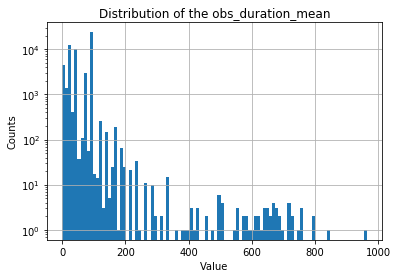

In [7]:
# plotted as before
use_db.obs_duration_mean.hist(bins=100)
plt.yscale("log")
plt.title("Distribution of the obs_duration_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

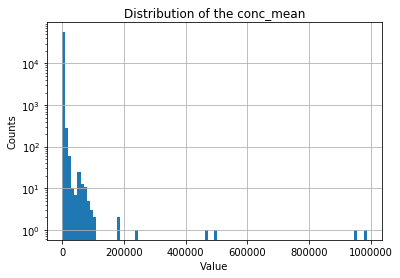

In [8]:
# plotted as before
use_db.conc1_mean.hist(bins=100)
plt.yscale("log")
plt.title("Distribution of the conc_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

In [9]:
# logarithmic transformations
use_db.obs_duration_mean = use_db.obs_duration_mean.apply(lambda x: np.log1p(x))
#use_db.conc1_mean = use_db.conc1_mean.apply(lambda x: np.log1p(x)) #Not good result

In [10]:
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = minmax.transform(use_db[["obs_duration_mean"]])

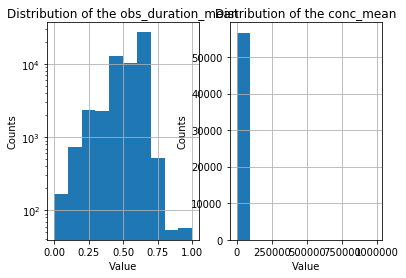

In [11]:
plt.subplot(1,2,1)
use_db.obs_duration_mean.hist(bins=10)
plt.title("Distribution of the obs_duration_mean")
plt.xlabel("Value")
plt.ylabel("Counts")
plt.yscale("log")
plt.subplot(1,2,2)
use_db.conc1_mean.hist(bins=10)
plt.title("Distribution of the conc_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

In [12]:
use_db.describe()

,test_cas,obs_duration_mean,conc1_mean
count,5.662900e+04,56629.000000,5.662900e+04
mean,1.236581e+07,0.561789,3.532387e+02
std,3.482018e+07,0.129865,7.121918e+03
min,5.000000e+04,0.000000,5.200000e-08
25%,1.080540e+05,0.468087,1.800000e-01
50%,1.918021e+06,0.566067,2.260000e+00
75%,1.004301e+07,0.665496,2.240000e+01
max,1.413933e+09,1.000000,9.860000e+05


In [13]:
# standardization
scaler = StandardScaler()
scaler.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = scaler.transform(use_db[["obs_duration_mean"]])

In [14]:
use_db.to_csv("output/db_obs_preproc.csv")

### For the concentration, no preprocessing considering this will be used as label for the regression case. Logarithmic transformation doesn't seem effective, scaling could be better

### categorical features  
We will need to encode exposure_type, conc1_type, class, tax_order, family_genus, species. Not done now because we will encoding depending on the case

In [15]:
# Category encoding
#use_db = pd.get_dummies(use_db)

## CAS - SMILES Processing

In [16]:
smiles = pd.read_csv('output/cas_to_smiles.csv', error_bad_lines=False).drop(columns="Unnamed: 0")

In [17]:
smiles.head()

,cas,smiles
0,10108-64-2,[Cl-].[Cl-].[Cd++]
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...
3,25474-41-3,NaN
4,540-72-7,[Na+].[S-]C#N


In [18]:
nulls_smiles = smiles[smiles['smiles'].isnull()].index.tolist()
cas = smiles[['cas']].iloc[nulls_smiles,:]
no_smiles = list(cas['cas'])

In [19]:
base_db['test_cas'] = base_db['test_cas'].apply(to_cas)

In [20]:
len(base_db[base_db['test_cas'].isin(no_smiles)])/len(base_db)

0.052570237863991946

Since is only the 5% of the total we decide to drop those columns.

In [21]:
smiles = smiles.rename(columns={'cas':'test_cas'})

In [22]:
base_db = pd.merge(base_db, smiles, on='test_cas')

In [23]:
null = base_db[base_db['smiles'].isnull()].index.tolist()

In [24]:
len(null)

2977

In [25]:
base_db_smiles = base_db.drop(null,axis=0)

#### Computing new features from SMILES

In [26]:
base_db_smiles['atom_number'] = base_db_smiles['smiles'].apply(atom_number)
base_db_smiles['alone_atom_number'] = base_db_smiles['smiles'].apply(alone_atom_number)
base_db_smiles['tripleBond'] = base_db_smiles['smiles'].apply(count_tripleBond)
base_db_smiles['doubleBond'] = base_db_smiles['smiles'].apply(count_doubleBond)

In [27]:
base_db_smiles['bonds_number'] = base_db_smiles['smiles'].apply(bonds_number)

In [28]:
base_db_smiles['ring_numer'] = base_db_smiles['smiles'].apply(ring_numer)

In [29]:
base_db_smiles['Mol'] = base_db_smiles['smiles'].apply(Mol)

In [30]:
base_db_smiles['MorganDensity'] = base_db_smiles['smiles'].apply(MorganDensity)

In [31]:
base_db_smiles['LogP'] = base_db_smiles['smiles'].apply(LogP)

In [32]:
base_db_smiles.head(5)

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,...,smiles,atom_number,alone_atom_number,tripleBond,doubleBond,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,10108-64-2,S,48.0,T,46.900,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,...,[Cl-].[Cl-].[Cd++],3,3,0,0,0,0,183.318,0.666667,-5.9945
1,10108-64-2,S,24.0,T,200.000,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Fundulus,heteroclitus,...,[Cl-].[Cl-].[Cd++],3,3,0,0,0,0,183.318,0.666667,-5.9945
2,10108-64-2,F,96.0,T,0.001,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,...,[Cl-].[Cl-].[Cd++],3,3,0,0,0,0,183.318,0.666667,-5.9945
3,10108-64-2,S,96.0,T,15.900,Actinopterygii,Cyprinodontiformes,Cyprinodontidae,Cyprinodon,variegatus,...,[Cl-].[Cl-].[Cd++],3,3,0,0,0,0,183.318,0.666667,-5.9945
4,10108-64-2,F,694.0,T,0.030,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,...,[Cl-].[Cl-].[Cd++],3,3,0,0,0,0,183.318,0.666667,-5.9945


In [33]:
base_db_smiles.to_csv("output/base_db_smiles.csv", index=False)